# PW7 - Sequence classification using recurrent neural networks
Objective : Classification of opinions based on film comments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import layers 


# Data
IMDB Database, giving positive/negative opinions on films. For each film, several couples (review/opinion (0/1)). 
For this study, we only consider the `num_words` most current words.

In [ ]:
num_words = 20000
# Database
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

#correspondence word -> index
word_index = imdb.get_word_index()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

index->word correspondence, adding some special words

In [ ]:
index = {word_id + 3: word for word, word_id in word_index.items()}
index[0] = "<pad>" # padding
index[1] = "<sos>" # start of sequence
index[2] = "<oov>" # out of vocabulary
index[3] = "<unk>" # unknown

Read review

In [ ]:
def decode_review(word_ids):
    return " ".join([index.get(word_id, "<err>") for word_id in word_ids])

print("*** An example of review : ***\n ",decode_review(X_train[1]))
print("*** Corresponding opinion [positive (1)/negative (0)] : ",y_train[1]," ***")

*** An example of review : ***
  <sos> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <oov> sickening that men actually wore them and the music is just <oov> trash that plays over and over again in almost every scene there is trashy music boobs and <oov> taking away bodies and the gym still doesn't close for <oov> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was b

# Models

## Baseline
Baseline model (provided), in order to compare the results to the recurrent neural network model

In [ ]:
X_train_text = [decode_review(words_ids) for words_ids in X_train]
X_test_text = [decode_review(words_ids) for words_ids in X_test]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
processing = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', SGDClassifier(max_iter=50)),])
processing.fit(X_train_text, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                     

In [ ]:
print("Baseline accuracy on the test set: we have to do better than this !!: ",processing.score(X_test_text, y_test))
print("Model testing  (ground truth: 0): ", processing.predict(["Awful !"]))
print("Model testing (ground truth: 1): ", processing.predict(["Awesome !"]))

Baseline accuracy on the test set: we have to do better than this !!:  0.88552
Model testing  (ground truth: 0):  [0]
Model testing (ground truth: 1):  [1]


## LSTM Model

First transform X_train (and X_test) into  2D array of shape (X_train.shape[0], maxlen) ((X_test.shape[0], maxlen)). X_train[i]  (X_test[i]) is a sequence of samples 
(a set of word indexes). There are X_train.shape[0]  (X_test.shape[0]) sequences, all with different lengths (the reviews)
So the function pads the sequences to the same dimension with padding values = 0 (default) : see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)



In [ ]:
maxlen = 625

print("Default:")
print(X_train.shape)
print(X_train)
print("\n")

X_train_trim = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

print("Padding:")
print(X_train_trim.shape)
print(X_train_trim)
print("\n")

print("y:")
print(y_train)
print(y_train.shape)

Default:
(25000,)
[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 19

Model : sequential model composed of 
- An [embedding](https://keras.io/api/layers/core_layers/embedding/) layer : the size of the vocabulary (input_dim) is given by the number of words. The size of the embedding space is the output_dim (see summary)
- An [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) with a given number of units (see summary)
- A [dense](https://keras.io/api/layers/core_layers/dense/) layer for the prediction

In [ ]:
#TODO

input_dim = num_words
embedding_dim = 128

# model = keras.Sequential()
# model.add(Embedding(input_dim=input_dim, output_dim=embedding_dim, name="embedding"))
# model.add(LSTM(32, name="LSTM"))
# model.add(Dense(1, activation="sigmoid", name="dense"))


# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(input_dim, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         114816    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512 

Compile and train the model. Use `binary_crossentropy` as a loss and `RMSProp`as optimizer. Track the accuracy

In [ ]:
batch_size = 32
num_epochs = 3

#TODO
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['acc'])

history = model.fit(x=X_train_trim, y=y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_test_trim, y_test))

Epoch 1/3
782/782 [==============================] - 43s 53ms/step - loss: 0.5931 - acc: 0.6206 - val_loss: 0.3107 - val_acc: 0.8687
Epoch 2/3
782/782 [==============================] - 41s 53ms/step - loss: 0.2163 - acc: 0.9187 - val_loss: 0.3138 - val_acc: 0.8689
Epoch 3/3
782/782 [==============================] - 41s 53ms/step - loss: 0.1041 - acc: 0.9638 - val_loss: 0.3876 - val_acc: 0.8606


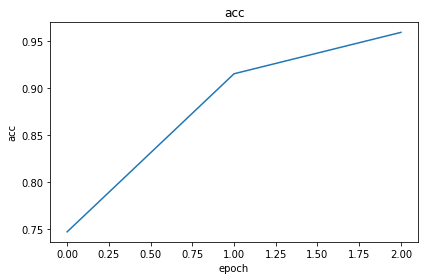

In [ ]:
# if `history`is the output of your fit.
plt.plot(history.history['acc'])
plt.title('acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.tight_layout()

Assess your model on the test set.

In [ ]:
def encode_review(toto):
    l = []
    l = [word_index.get(word) for word in toto]
    l = [l[i :(i+1)] for i in range(len(l))]
    l = tf.keras.preprocessing.sequence.pad_sequences(l, maxlen=maxlen)
    return l

#TODO
print("Evaluate on test data:")
results = model.evaluate(X_test_trim, y_test, batch_size=batch_size)
print("test loss, test acc:", results)

negative = ["awful"]
negative = encode_review(negative)
print("Model testing  (ground truth: 0): ", model.predict_classes(negative))

positive = ["fantastic"]
positive = encode_review(positive)
print("Model testing  (ground truth: 1): ", model.predict_classes(positive))

Evaluate on test data:
782/782 [==============================] - 6s 8ms/step - loss: 0.3876 - acc: 0.8606
test loss, test acc: [0.3876391351222992, 0.8605599999427795]


# Some ways to test/improve the method

- Change the size of the vocabulary
- change the sier of the padding
- Change the dimension of the embedding space
- Change the number of units of the LSTM
- Change the model (The [Keras website](https://keras.io/examples/nlp/text_classification_from_scratch/) proposes another model on the same database, you can be inspired from it)
- 

... and analyze how it improves (or not) the model


